In [1]:
#Loading Libraries

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image 

2024-03-14 01:42:20.103982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = tf.keras.models.load_model('./output/model.keras')

# Show the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 30)         0         
 2D)                                                    

2024-03-14 01:42:21.510230: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Reading the sudoku puzzle

**In this section:**

* Read an image from the dataset 
* Preprocess the image 

_16_9176653.jpeg


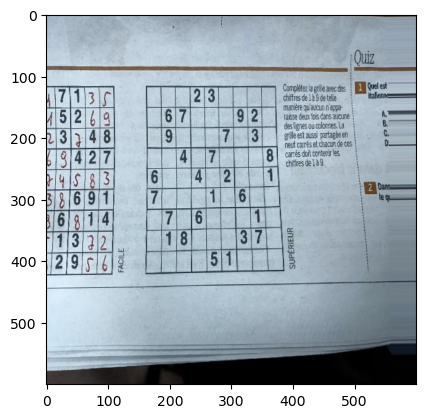

In [3]:
# Randomly select an image from the dataset 

folder=r"./input/sudoku-boxes/aug"

a=random.choice(os.listdir(folder))
print(a)
sudoku_a = cv2.imread(folder+'/'+a)
plt.figure()
plt.imshow(sudoku_a)
plt.show() 

In [4]:
# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

# Fetching Images

Because some images of our dataset have blurry text, the algorithm may not work well. Hence, the below problem is solved using a sample image, with a commented line to which can be used to showcase an actual test instead, if wanted.
    * Option One: Using an ideal puzzle
    * Option Two: Using the random puzzle

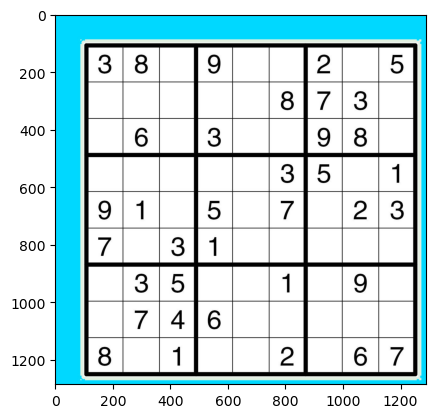

In [5]:
# Importing puzzle to be solved
puzzle = cv2.imread("./input/ideal-scenario/su.jpg")
#puzzle = cv2.imread(folder+'/'+a)

#let's see what we got
plt.figure()
plt.imshow(puzzle)
plt.show()


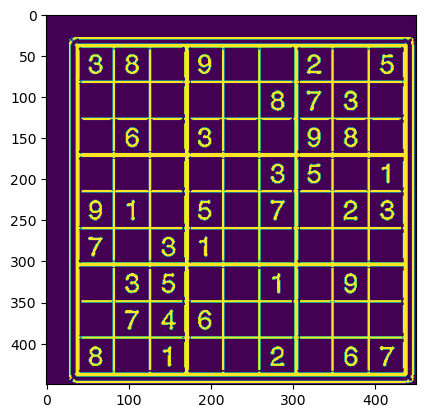

In [6]:
# Resizing puzzle to be solved
puzzle = cv2.resize(puzzle, (450,450))
# Preprocessing Puzzle 
su_puzzle = preprocess(puzzle)

#let's look at what we have got
plt.figure()
plt.imshow(su_puzzle)
plt.show()

# DETECTING CONTOUR

* Detect the biggest contour of the image.
* Reshaping the outline to get the cropped and well-aligned Sudoku

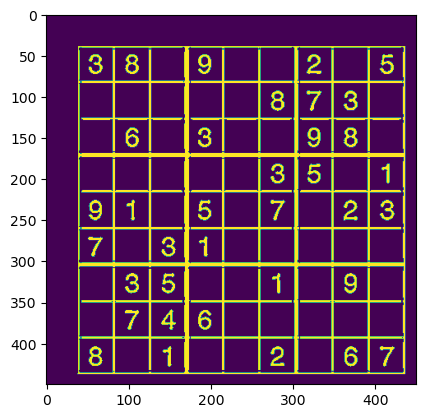

In [7]:
# Finding the outline of the sudoku puzzle in the image
su_contour_1= su_puzzle.copy()
su_contour_2= su_puzzle.copy()
su_contour, hierarchy = cv2.findContours(su_puzzle,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(su_contour_1)
plt.show()

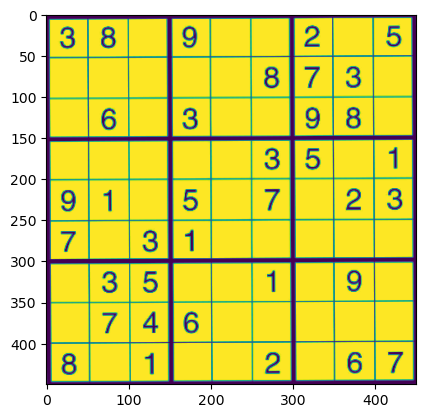

In [8]:
black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
    cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
    su_pts1 = np.float32(su_biggest)
    su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)  
    su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
    su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

# SPLITTING THE CELLS AND CLASSIFYING DIGITS

* Splitting the sudoku box into 81 cells with empty spaces or digits 
* Cropping the cells to avoid misdetection of boundary lines as digits
* Using the model to classify the digits in the cells such that the empty cells are classified as zero
* Getting the detected output in the form of an array of 81 digits 

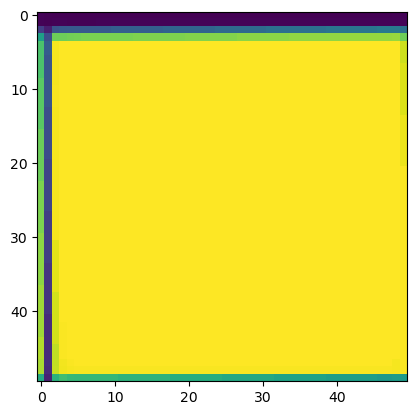

In [9]:
sudoku_cell = splitcells(su_imagewrap)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[58])
plt.show()

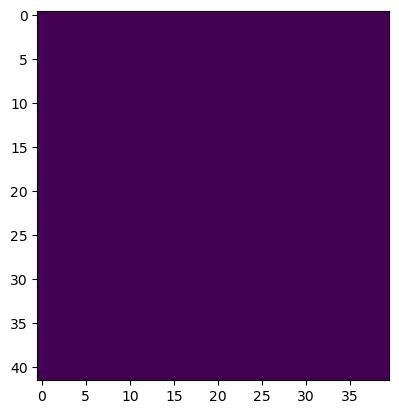

In [10]:
# The sudoku_cell's output includes the boundaries this could lead to misclassifications by the model 
# I am cropping the cells to avoid that
# sneeking in a bit of PIL lib as cv2 was giving some weird error that i couldn't ward off

def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[58])
plt.show()

In [11]:
def read_cells(cell,model):

    result = []
    for image in cell:
        # preprocess the image as it was in the model 
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        # getting predictions and setting the values if probabilities are above 65% 
        
        predictions = model.predict(img)
        classIndex = np.argmax(predictions,axis=1)
        probabilityValue = np.amax(predictions)
        
        if probabilityValue > 0.65:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)

1/1 [==============================] - 0s 66ms/step


# Solving the sudoku using a recursive technique

* Reshaping the array into a 9 x 9 matrix 
* Solving the matrix using recursion

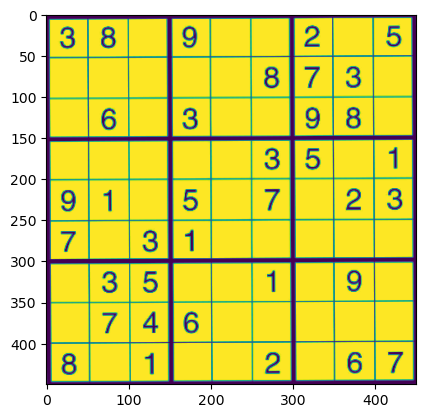

In [12]:
#For comparision
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

In [13]:
# Print a sudoku puzzle
def printPuzzle(quiz):
    for row in range(9):
        if row % 3 == 0 and row != 0:
            print("....................")

        for col in range(9):
            if col % 3 == 0 and col != 0:
                print("|", end=" ")

            if col == 8:
                print(quiz[row][col])
            else:
                print(str(quiz[row][col]) + " ", end="")
                
            

In [14]:
# Reshaping the grid to a 9x9 matrix

grid = np.reshape(grid,(9,9))
printPuzzle(grid)

3 8 0 | 9 0 0 | 2 0 5
0 0 0 | 0 0 8 | 7 3 0
0 6 0 | 3 0 0 | 9 8 0
....................
0 0 0 | 0 0 3 | 5 0 1
9 1 0 | 5 0 7 | 0 2 3
7 0 3 | 1 0 0 | 0 0 0
....................
0 3 5 | 0 0 1 | 0 9 0
0 7 4 | 6 0 0 | 0 0 0
8 0 1 | 0 0 2 | 0 6 7


We only consider numbers with a classification rate above 65% as considering anything below might result in an unsolvable sudoku puzzle.

P.S. Adding an arbitrary number could lead to a puzzle with no solution. Whereas, removing numbers increase the combinations.

In [15]:
# Checks whether it will be legal to assign num to the given row, col
def isPossibleToAssign(grid, row, col, num):
 
    # Check for same num in row
    for x in range(9):
        if grid[row][x] == num:
            return False
 
    # Check for same num in column
    for x in range(9):
        if grid[x][col] == num:
            return False
 
    # Check for same num in 3*3 matrix
    startRow = row - row % 3
    startCol = col - col % 3
    for i in range(3):
        for j in range(3):
            if grid[i + startRow][j + startCol] == num:
                return False
    return True

In [16]:
def solveSudokuPuzzle(grid, row, col):
    # 9x9 matrix
    N = 9
    # Check if we reached the end
    if (row == N - 1 and col == N):
        return True
 
    # Check if column value becomes 9, then move to the next row
    if col == N:
        row += 1
        col = 0
 
    # If it already has a value, move on
    if grid[row][col] > 0:
        return solveSudokuPuzzle(grid, row, col + 1)
    for num in range(1, N + 1, 1):
 
        # Check if it is safe to place the number at that spot
        if isPossibleToAssign(grid, row, col, num):
            grid[row][col] = num
 
            # Checking for next possibility with next col
            if solveSudokuPuzzle(grid, row, col + 1):
                return True
 
        # Removing the assigned num since our assumption was wrong
        grid[row][col] = 0
    return False

In [17]:
if (solveSudokuPuzzle(grid, 0, 0)):
    printPuzzle(grid)
else:
    print("Solution doesn't exist. Model misread digits, probably.")

3 8 7 | 9 6 4 | 2 1 5
5 4 9 | 2 1 8 | 7 3 6
1 6 2 | 3 7 5 | 9 8 4
....................
4 2 6 | 8 9 3 | 5 7 1
9 1 8 | 5 4 7 | 6 2 3
7 5 3 | 1 2 6 | 8 4 9
....................
6 3 5 | 7 8 1 | 4 9 2
2 7 4 | 6 3 9 | 1 5 8
8 9 1 | 4 5 2 | 3 6 7
